In [1]:
# For Google Colab
# Upload the folder containing this file to google drive.
# Make sure that uninformed_informed_search.py is also in the same folder in google drive.
import sys, os

# Checking if the notebook is opened in google colab
#If YES, mount the google drive and change the directory
if 'google.colab' in sys.modules:

    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')

    # change path to the folder
    path = '/content/drive/My Drive/IT5005/Lecture 8 HMM'
    print(path)
    #os.chdir changes the current working directory
    os.chdir(path)
    !pwd

# Bayesian Filtering for Robot Localization


This code presents a Hidden Markov Model (HMM) for the grid shown below to simulate and visualize the localization process of a robot navigating a grid. The grid comprises 3 rows and 4 columns. The objective is to determine its position based on sensor readings over time. The grid contains a single blocked cell where the robot cannot enter. The goal is to model the robot's movement and sensor observations, then visualize the probability distribution of the robot's location as it moves through the grid.  The tuple $(i,j)$ indicates the cell number and $s=c$ indicates state of corresponding cell is $c$. The robot can only move either horizontally or vertically. The red lines represent walls. If the robot bounces into wall, it stays in the same cell.

![HMM 4x# Grid](HMM_4X3_Grid.png)

The parameters **transition_model**, **sensor_model** and **prior** defines the HMM.

**Reference:**

AIMA4e: Section 14.3.2 Hidden Markov Model Example: Localization

## transition_model ($\mathbf{T}$)

- The robot has a conditional probability of 0.2 of staying in the same cell.

- The robot has a conditional probability of 0.8 of moving to one of its valid neighboring cells. This probability is equally distributed among all accessible neighboring cells.

- The robot cannot move into the blocked cell, and the blocked cell is excluded from the list of valid neighboring cells.


Let $X_t$ be the state of the robot at time $t$, and let $X_{t+1} $ be the state of the robot at time $t+1$. The conditional transition probabilities are defined as follows:


- Probability of staying in the same cell:

  $P(X_{t+1} = s | X_t = s) = 0.2$


- Probability of moving to a neighboring cell:

  $ P(X_{t+1} = s' | X_t = s) = \frac{0.8}{\text{N(s)}} $


where
  - $ s $ is the current state
  
  - $ s' $ is one of the valid neighboring states.

  - $N(s)$ is the number of valid neighbours


$ P(X_{t+1} = s'' | X_t = s) = 0 $

where
  - $s'' \notin N(s)$

### Example:

$P(X_{t+1} = 6 | X_t = 6) = 0.2$

$P(X_{t+1} = 2 | X_t = 6) = \frac{0.8}{3}$

$P(X_{t+1} = 10 | X_t = 6) = \frac{0.8}{3}$

$P(X_{t+1} = 7 | X_t = 6) = \frac{0.8}{3}$

$P(X_{t+1} = 0 | X_t = 6) = 0$



## Sensor Model ($\mathbf{O}_t$)

Sensor mounted on the robot indicates the presence of walls. For example, a sensor reading of 'WS' indicates the presence of wall to the West and South of the current cell.

The sensor model defines the probabilities associated with the robot's sensor readings given its actual location in the grid. This model accounts for the possibility of sensor errors and ensures that the blocked cell has a zero probability of being detected.

### Parameters to define sensor model:

- **Error Rate** ($p$): The sensor readings have a certain error rate, which represents the probability that the sensor might incorrectly interpret the surroundings.

For example, $p=0$ indicates that the sensor is error-free and no discrepancies in the sensor readings.

- **Discrepancies** ($d$): The model calculates the probability of sensor readings based on the number of discrepancies between the actual surroundings and the observed sensor readings.

For example, if the robot is at cell (1,1) and its sensor readings are "NEWS", then the number of descrepancies are 2, as there are no walls to the North and East of cell (1,1)


### Conditional Probabilities:

Let $E_t$ be the evidence (sensor reading) at time $t$, and let $S_t$ be the state of the robot at time $t$. The conditional probabilities for the sensor model are defined as follows:


- Probability of observing a sensor reading given the actual state (Refer Section 14.3.2 of AIMA4e):

  $P(E_t = e | X_t = s) = (1 - \text{p})^{4 - d} \times \text{p}^{\text{d}}$


where:

- $p$ is the probability of a sensor error.

- $d$ is the number of differences between the actual walls and the observed sensor reading.

The $sensor\_model$ (or observation matrix $\mathbf{O}$) is a diagonal matrix and it is formed with $P(E_t = e | X_t = s)$ as the diagonal elememts. The size of the $sensor\_model$ is $|S| \times |S|$, where $|S|$ is the number of states.

The parameter 'error_rate' in the method "sensor_distribution" is the $p$. Try different values (between 0 and 1) for 'error_rate'.

Example: In a state $s=6$ with a wall to the West:

  - if the sensor detects walls on all four sides, then the number of descrepencies $d = 3$ and the probability of this evidence $e$ is 

    $P(E_t = e | X_t = s) = (1 - \text{p})^{1} \times \text{p}^{\text{3}}$

  - if the sensor detects a wall only on the West, then the number of descrepencies $d = 0$ and the probability of this evidence $e$ is 

    $P(E_t = e | X_t = s) = (1 - \text{p})^{4} \times \text{p}^{\text{0}}$   



# Forward Algorithm

$ \mathbf{f}_{1:t+1} = \alpha \mathbf{O}_{t+1} \mathbf{T}^T \mathbf{f}_{1:t} $

where
 -  $\mathbf{f}_{1:t+1} = \mathbf{P}(X_{t+1}|E_{1:t+1})$
 -  $\mathbf{f}_{1:t} = \mathbf{P}(X_{t+1}|E_{1:t})$
 -  $T_{i,j} = P(X_{t+1} = j |X_t = i)$ and $T_{i,j}$ is the element of $\mathbf{T}$ at i-th row and j-th column
 -  $\mathbf{O}_{t+1}$ is a diagonal matrix with $O_{i,i} = P(E_{t+1}|X_{t+1} = i )$ as the diagonal element
 -  $\alpha$ is the normalization constant


In [2]:
!pip install celluloid seaborn matplotlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import matplotlib.animation as animation
from celluloid import Camera
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


In [4]:
class HMMGrid:

    # Grid dimensions
    rows = 3
    cols = 4
    block = (2, 2)  # Block at (2, 2) in 1-indexed format

    def __init__(self,p = 0.25):
        self.transition_model = None
        self.sensor_model = None
        self.prior = None
        self.p = p
        self.build_transition_model()  # builds transitin model for Grid
        self.define_prior()  # builds prior distribution


    def build_transition_model(self):
        self.transition_model = np.zeros((self.rows * self.cols, self.rows * self.cols))
        for j in range(1, self.rows + 1):
            for i in range(1, self.cols + 1):
                if (i, j) == self.block:
                    continue  # Skip the blocked cell
                state = self.coord_to_state(i, j)
                neighbors = self.get_neighbors(i, j)
                num_neighbors = len(neighbors)
                if num_neighbors > 0:
                    move_prob = 0.8 / num_neighbors
                    self.transition_model[state][state] = 0.2  # probability of staying in the same state
                    for ni, nj in neighbors:
                        next_state = self.coord_to_state(ni, nj)
                        self.transition_model[state][next_state] = move_prob
                else:
                    self.transition_model[state][state] = 1.0
    def define_prior(self):
        total_states = self.rows * self.cols
        valid_states = total_states
        self.prior = np.zeros(total_states)
        for j in range(1, self.rows + 1):
            for i in range(1, self.cols + 1):
                if (i, j) != self.block:
                    state = self.coord_to_state(i, j)
                    self.prior[state] = 1.0 / valid_states


    def build_transition_model_(self):
        self.transition_model = np.zeros((self.rows * self.cols, self.rows * self.cols))
        for j in range(1, self.rows + 1):
            for i in range(1, self.cols + 1):
                if (i, j) == self.block:
                    continue  # No transition model for blocked cell
                state = self.coord_to_state(i, j)
                neighbors = self.get_neighbors(i, j)

                if neighbors:
                    prob = 1.0 / len(neighbors)
                    for ni, nj in neighbors:
                        next_state = self.coord_to_state(ni, nj)
                        self.transition_model[state][next_state] = prob

    def get_neighbors(self, i, j):
        neighbors = []
        if j < self.rows and (i, j + 1) != self.block:
            neighbors.append((i, j + 1))
        if j > 1 and (i, j - 1) != self.block:
            neighbors.append((i, j - 1))
        if i > 1 and (i - 1, j) != self.block:
            neighbors.append((i - 1, j))
        if i < self.cols and (i + 1, j) != self.block:
            neighbors.append((i + 1, j))
        return neighbors

    def coord_to_state(self, i, j):
        return (j - 1) * self.cols + (i - 1)

    def state_to_coord(self, state):
        return (state % self.cols + 1, state // self.cols + 1)


    def sensor_distribution(self, ev):
        # parameter p = error_rate
        # change this value and observe its effect on the output of forward algorithm
        error_rate =self.p
        sensor_dist = []
        no_discrepancies = self.get_discrepancies(ev)

        for number in no_discrepancies:
            probability = (1 - error_rate) ** (4 - number) * error_rate ** number
            sensor_dist.append(probability)
        self.sensor_model = np.diag(sensor_dist)

        # Explicitly set the sensor probability of the blocked cell to zero
        if self.block:
            block_state = self.coord_to_state(*self.block)
            if block_state < len(self.sensor_model):
                self.sensor_model[block_state, block_state] = 0.0


    def get_walls(self):
        walls = {}
        for i in range(1, self.cols + 1):
            for j in range(1, self.rows + 1):
                # Initialize wall string for the cell
                wall_str = ''
                # Check for boundary walls
                if i == 1:  # West boundary
                    wall_str += 'W'
                if i == self.cols:  # East boundary
                    wall_str += 'E'
                if j == 1:  # South boundary
                    wall_str += 'S'
                if j == self.rows:  # North boundary
                    wall_str += 'N'
                # Add the cell to the walls dictionary if it has any walls
                if wall_str:
                    walls[(i, j)] = wall_str



        # Include BLOCK effects on neighboring cells
        if self.block:
            block_i, block_j = self.block
            if block_j < self.rows:
                walls[(block_i, block_j + 1)] = walls.get((block_i, block_j + 1), '') + 'S'
            if block_j > 1:
                walls[(block_i, block_j - 1)] = walls.get((block_i, block_j - 1), '') + 'N'
            if block_i > 1:
                walls[(block_i - 1, block_j)] = walls.get((block_i - 1, block_j), '') + 'E'
            if block_i < self.cols:
                walls[(block_i + 1, block_j)] = walls.get((block_i + 1, block_j), '') + 'W'

        return walls

    def get_discrepancies(self, sensor_reading):
        walls = self.get_walls()
        discrepancies = []
        for j in range(1, self.rows + 1):
            for i in range(1, self.cols + 1):
                if (i, j) == self.block:
                    discrepancies.append(0)
                    continue
                actual = set(walls.get((i, j), ''))
                observed = set(sensor_reading)
                discrepancies.append(len(actual.symmetric_difference(observed)))
        return discrepancies

    def plot_grid_layout(self):
        fig, ax = plt.subplots()
        # Draw the grid
        for j in range(1, self.rows + 1):
            for i in range(1, self.cols + 1):
                if (i, j) == self.block:
                    ax.add_patch(patches.Rectangle((i - 1, j - 1), 1, 1, edgecolor='red', facecolor='black'))
                else:
                    ax.add_patch(patches.Rectangle((i - 1, j - 1), 1, 1, edgecolor='black', facecolor='none'))
        line_width = 4
        walls = self.get_walls()
        # Draw walls
        for (i, j), wall in walls.items():
            if 'N' in wall:
                ax.plot([i - 1, i], [j, j], color='red',linewidth=line_width)
            if 'S' in wall:
                ax.plot([i - 1, i], [j - 1, j - 1], color='red',linewidth=line_width)
            if 'W' in wall:
                ax.plot([i - 1, i - 1], [j - 1, j], color='red',linewidth=line_width)
            if 'E' in wall:
                ax.plot([i, i], [j - 1, j], color='red',linewidth=line_width)


        # Draw the outer boundary walls
        for i in range(self.cols):
            ax.plot([i, i + 1], [0, 0], color='red',linewidth=line_width)  # Bottom boundary
            ax.plot([i, i + 1], [self.rows, self.rows], color='red',linewidth=line_width)  # Top boundary

        for j in range(self.rows):
            ax.plot([0, 0], [j, j + 1], color='red',linewidth=line_width)  # Left boundary
            ax.plot([self.cols, self.cols], [j, j + 1], color='red',linewidth=line_width)  # Right boundary

        # Set the limits and display the plot
        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_aspect('equal')
        plt.gca().invert_yaxis()
        plt.show()

    def plot_animated_heatmap(self, path, interval=500):
        fig, ax = plt.subplots(figsize=(8, 5))
        camera = Camera(fig)
        for frame in range(len(path)):
            probability_vector = path[frame]
           # Create a grid initialized with zeros
            grid = np.zeros((self.rows, self.cols))
            # Fill the grid with probabilities from the probability vector
            for state in range(len(probability_vector)):
                i, j = self.state_to_coord(state)
                grid[self.rows - j, i - 1] = probability_vector[state]  # row index should be inverted

            colors = ["black", "red"]
            cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
            sns.heatmap(grid, annot=True, cmap=cmap, cbar=False, linewidths=.5, linecolor='black', ax=ax)
            ax.set_title(f'Probability Distribution Heatmap with p = {self.p}')
            ax.set_xlabel('Columns')
            ax.set_ylabel('Rows')
            camera.snap()
        animation = camera.animate(interval=interval)
        # Display the animation within Jupyter Notebook
        return HTML(animation.to_html5_video())




# Grid display

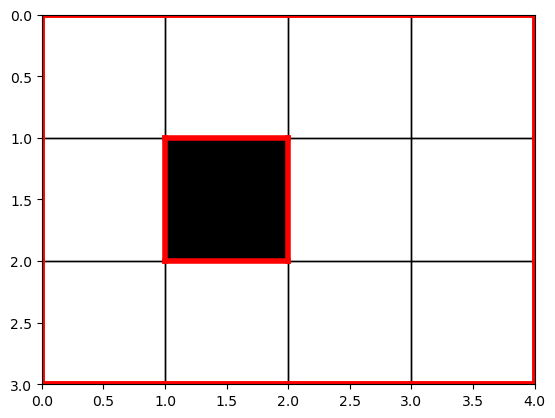

In [5]:
hmm = HMMGrid(p=0.2)
hmm.plot_grid_layout()

# Transition Model ($\mathbf{T}$)

In [6]:
import pandas as pd

def pretty_print_transition_matrix(transition_model):
    if transition_model is None:
        print("Transition model is not defined.")
        return

    df = pd.DataFrame(transition_model)
    print("Transition Matrix:")
    print(df.to_string())
pretty_print_transition_matrix(transition_model=hmm.transition_model)

Transition Matrix:
     0         1         2         3    4    5         6         7    8         9         10        11
0   0.2  0.400000  0.000000  0.000000  0.4  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000
1   0.4  0.200000  0.400000  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000
2   0.0  0.266667  0.200000  0.266667  0.0  0.0  0.266667  0.000000  0.0  0.000000  0.000000  0.000000
3   0.0  0.000000  0.400000  0.200000  0.0  0.0  0.000000  0.400000  0.0  0.000000  0.000000  0.000000
4   0.4  0.000000  0.000000  0.000000  0.2  0.0  0.000000  0.000000  0.4  0.000000  0.000000  0.000000
5   0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000
6   0.0  0.000000  0.266667  0.000000  0.0  0.0  0.200000  0.266667  0.0  0.000000  0.266667  0.000000
7   0.0  0.000000  0.000000  0.266667  0.0  0.0  0.266667  0.200000  0.0  0.000000  0.000000  0.266667
8   0.0  0.000000  0.000000  0.000000  0.4  0.0  0.000

# Sensor Model (or observation matrix $\mathbf{O}_t$)

In [7]:
print("Sensor Model:")
#print(hmm.sensor_model)

def pretty_print_sensor_matrix(sensor_model):
    if sensor_model is None:
        print("Sensor model is not defined.")
        return

    df = pd.DataFrame(sensor_model)
    print("Sensor Distribution Matrix:")
    print(df.to_string())

pretty_print_sensor_matrix(sensor_model=hmm.sensor_model)

Sensor Model:
Sensor model is not defined.


In [8]:
print(hmm.prior)

[0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]


In [9]:
# List of sensor readings (sensor distributions)
sensor_readings = ['WS', 'EW', 'NW', 'NS', 'N']

# Sample observation matrix for the sensor reading 'WS'

In [10]:
hmm.sensor_distribution('WS')
pretty_print_sensor_matrix(hmm.sensor_model)

Sensor Distribution Matrix:
        0       1       2       3       4    5       6       7       8       9       10      11
0   0.4096  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
1   0.0000  0.0256  0.0000  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
2   0.0000  0.0000  0.1024  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
3   0.0000  0.0000  0.0000  0.0256  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
4   0.0000  0.0000  0.0000  0.0000  0.0256  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
5   0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
6   0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.1024  0.0000  0.0000  0.0000  0.0000  0.0000
7   0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0064  0.0000  0.0000  0.0000  0.0000
8   0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0000  0.0256  0.0000  0.0000  0.0000
9   0.0000  

# Forward Algorithm

$ \mathbf{f}_{1:t+1} = \alpha \mathbf{O}_{t+1} \mathbf{T}^T \mathbf{f}_{1:t} $

where
 -  $\mathbf{f}_{1:t+1} = \mathbf{P}(X_{t+1}|E_{1:t+1})$
 -  $\mathbf{f}_{1:t} = \mathbf{P}(X_{t+1}|E_{1:t})$
 -  $T_{i,j} = P(X_{t+1} = j |X_t = i)$ and $T_{i,j}$ is the element of $\mathbf{T}$ at i-th row and j-th column
 -  $\mathbf{O}_{t+1}$ is a diagonal matrix with $O_{i,i} = P(E_{t+1}|X_{t+1} = i )$ as the diagonal element
 - $\alpha$ is the normalization constant



In [11]:
# Updates the current probability distribution based on the sensor model and transition model
def forward(hmm_model, fvt, evt):
    #Calculate sensor_model or observation matrix
    hmm_model.sensor_distribution(evt)   #Observation matrix
    Otp1 = hmm_model.sensor_model
    temp = np.matmul(hmm_model.transition_model.T,fvt)
    fvt_plus_1_unnormalized = np.matmul(Otp1,temp)
    fvt_plus_1 = fvt_plus_1_unnormalized/np.sum(fvt_plus_1_unnormalized)
    return fvt_plus_1

In [12]:
# Function to perform inference
#sensor_readings contain a vector of vectors
#Each vector contains sensor model for a given evidence
def run_inference(hmm_model, sensor_readings):
    path = [hmm_model.prior]
    fvt = hmm_model.prior
    for evtp1 in sensor_readings:
        fvtp1 = forward(hmm_model,fvt, evtp1)
        path.append(fvtp1)
        fvt = fvtp1
    return path

# Run inference
path = run_inference(hmm, sensor_readings)
print(path)

[array([0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.        , 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333]), array([0.52958213, 0.0286857 , 0.16770101, 0.02427251, 0.03309888,
       0.        , 0.13239553, 0.01048131, 0.03309888, 0.0286857 ,
       0.01048131, 0.00151703]), array([2.91718125e-02, 3.66084894e-03, 5.02622445e-03, 1.16950059e-02,
       8.27848733e-01, 0.00000000e+00, 6.85931807e-02, 4.26243544e-02,
       6.99729286e-03, 3.03873047e-04, 2.76257557e-03, 1.31609880e-03]), array([5.57313698e-02, 2.26279745e-03, 1.04727835e-03, 1.54851812e-04,
       2.96471570e-02, 0.00000000e+00, 1.78914025e-02, 1.31823521e-03,
       8.76479105e-01, 5.92223653e-04, 1.28391762e-02, 2.03640275e-03]), array([3.77425574e-03, 5.81507153e-02, 3.75530865e-03, 1.04461628e-04,
       3.73725479e-03, 0.00000000e+00, 3.01213658e-04, 2.33271669e-04,
       2.95799313e-02, 8.94405679e-01, 5.29768283e-03, 6.60225699e-04]), array([7.89674752e-0

# Output of forward algorithm:  



sensor_readings = ['WS', 'EW', 'NW', 'NS', 'N']

   
    At t  = 1: sensor_readings = 'WS'

    At t  = 2: sensor_readings = 'EW'

    At t  = 3: sensor_readings = 'NW'

    At t  = 4: sensor_readings = 'NS'

    At t  = 5: sensor_readings = 'N'


when the sensor reading is 'NS', the robot can be at

        a. cell (2,1), i.e., state=2

        a. cell (2,3), i.e., state=9

Forward algorithm uses the state transision model and confirms that the robot is at cell (2,3), i.e., state = 9

Without the state transition model and prior evidence (previous samples in the evidence sequence), it is hard to estimate the location of the agent based on the sensor readings alone.



In [13]:
df_path = pd.DataFrame(path)
#First row (t=0) is prior distribution
print("Probability distribution across different time instants (rows are time instants and columns are states):")
print(df_path.to_string())


Probability distribution across different time instants (rows are time instants and columns are states):
         0         1         2         3         4    5         6         7         8         9         10        11
0  0.083333  0.083333  0.083333  0.083333  0.083333  0.0  0.083333  0.083333  0.083333  0.083333  0.083333  0.083333
1  0.529582  0.028686  0.167701  0.024273  0.033099  0.0  0.132396  0.010481  0.033099  0.028686  0.010481  0.001517
2  0.029172  0.003661  0.005026  0.011695  0.827849  0.0  0.068593  0.042624  0.006997  0.000304  0.002763  0.001316
3  0.055731  0.002263  0.001047  0.000155  0.029647  0.0  0.017891  0.001318  0.876479  0.000592  0.012839  0.002036
4  0.003774  0.058151  0.003755  0.000104  0.003737  0.0  0.000301  0.000233  0.029580  0.894406  0.005298  0.000660
5  0.000790  0.007004  0.002988  0.000034  0.000436  0.0  0.000314  0.000054  0.180866  0.095157  0.711562  0.000796


# Plotting the output of forward algorithm

 Each snapshot of the video indicates the probability of the robot in a given cell

 Red indicates large value and black indicates lowest value of the vector

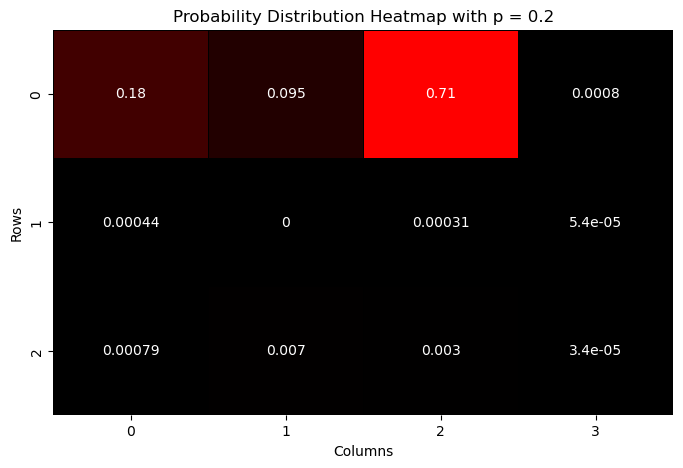

In [14]:
hmm.plot_animated_heatmap(path)
